In [ ]:
import os
import cv2
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K


In [20]:
def load_coil20_images(folder_path, image_size=(64, 64)):
    data_dict = {}
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            obj_id = int(filename.split('_')[0].replace('obj', ''))
            img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, image_size)
            img = np.expand_dims(img.astype('float32') / 255.0, axis=-1)
            if obj_id not in data_dict:
                data_dict[obj_id] = []
            data_dict[obj_id].append(img)
    return data_dict

coil20_path = './coil-20-proc'
data_dict = load_coil20_images(coil20_path)


In [21]:
def create_pairs(data_dict, max_pairs_per_object=50):
    pairs, labels = [], []
    object_ids = sorted(list(data_dict.keys()))
    for obj_id in object_ids:
        images = data_dict[obj_id]
        random.shuffle(images)
        for i in range(min(max_pairs_per_object, len(images) // 2)):
            pairs.append([images[2 * i], images[2 * i + 1]])
            labels.append(1)
            diff_obj_id = random.choice([oid for oid in object_ids if oid != obj_id])
            img3 = random.choice(data_dict[diff_obj_id])
            pairs.append([images[2 * i], img3])
            labels.append(0)
    return np.array(pairs), np.array(labels)

pairs, labels = create_pairs(data_dict)
X1 = pairs[:, 0]
X2 = pairs[:, 1]
y = labels.astype('float32')


In [22]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(
    X1, X2, y, test_size=0.2, random_state=42
)


In [23]:
def create_base_network(input_shape):
    input_layer = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(input_layer)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(input_layer, x)

input_shape = X1_train[0].shape
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)
processed_a = base_network(input_a)
processed_b = base_network(input_b)

def abs_diff(vectors):
    x, y = vectors
    return K.abs(x - y)

distance = Lambda(abs_diff)([processed_a, processed_b])
output = Dense(1, activation='sigmoid')(distance)

model = Model([input_a, input_b], output)


In [24]:
def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, tf.float32)
    return tf.reduce_mean(
        y_true * tf.square(y_pred) +
        (1 - y_true) * tf.square(tf.maximum(margin - y_pred, 0))
    )

model.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])


In [25]:
history = model.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_test, X2_test], y_test),
    batch_size=32,
    epochs=10
)


Epoch 1/10
36/36 [==============================] - 5s 109ms/step - loss: 0.1756 - accuracy: 0.3186 - val_loss: 0.1274 - val_accuracy: 0.1910
Epoch 2/10
36/36 [==============================] - 4s 112ms/step - loss: 0.0906 - accuracy: 0.1111 - val_loss: 0.0849 - val_accuracy: 0.1042
Epoch 3/10
36/36 [==============================] - 4s 111ms/step - loss: 0.0534 - accuracy: 0.0521 - val_loss: 0.0798 - val_accuracy: 0.0903
Epoch 4/10
36/36 [==============================] - 4s 103ms/step - loss: 0.0355 - accuracy: 0.0365 - val_loss: 0.0674 - val_accuracy: 0.0799
Epoch 5/10
36/36 [==============================] - 3s 88ms/step - loss: 0.0221 - accuracy: 0.0226 - val_loss: 0.0616 - val_accuracy: 0.0694
Epoch 6/10
36/36 [==============================] - 3s 84ms/step - loss: 0.0176 - accuracy: 0.0148 - val_loss: 0.0475 - val_accuracy: 0.0556
Epoch 7/10
36/36 [==============================] - 3s 93ms/step - loss: 0.0101 - accuracy: 0.0069 - val_loss: 0.0512 - val_accuracy: 0.0625
Epoch 8/1

In [26]:
y_pred = model.predict([X1_test, X2_test])
for i in range(10):
    print(f"Pair {i+1}: True label={y_test[i]}, Predicted similarity={y_pred[i][0]:.4f}")


9/9 [==============================] - 0s 24ms/step
Pair 1: True label=1.0, Predicted similarity=0.0000
Pair 2: True label=0.0, Predicted similarity=1.0000
Pair 3: True label=1.0, Predicted similarity=0.1023
Pair 4: True label=0.0, Predicted similarity=0.2433
Pair 5: True label=1.0, Predicted similarity=0.0055
Pair 6: True label=1.0, Predicted similarity=0.0075
Pair 7: True label=1.0, Predicted similarity=0.0036
Pair 8: True label=1.0, Predicted similarity=0.0013
Pair 9: True label=0.0, Predicted similarity=0.9988
Pair 10: True label=1.0, Predicted similarity=0.0672


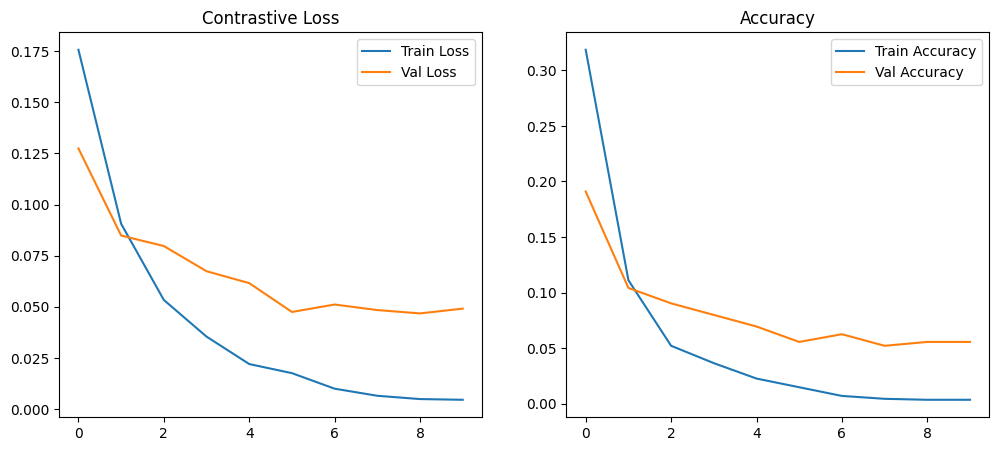

In [27]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Contrastive Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.show()


In [28]:
def euclidean_distance(vectors):
    x, y = vectors
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

distance_euclid = Lambda(euclidean_distance)([processed_a, processed_b])
model_euclid = Model([input_a, input_b], distance_euclid)

model_euclid.compile(loss=contrastive_loss, optimizer='adam', metrics=['accuracy'])

history_euclid = model_euclid.fit(
    [X1_train, X2_train], y_train,
    validation_data=([X1_test, X2_test], y_test),
    batch_size=32,
    epochs=10
)


Epoch 1/10
36/36 [==============================] - 4s 100ms/step - loss: 59.2511 - accuracy: 0.4826 - val_loss: 1.0848 - val_accuracy: 0.4062
Epoch 2/10
36/36 [==============================] - 4s 97ms/step - loss: 0.4461 - accuracy: 0.3628 - val_loss: 0.2497 - val_accuracy: 0.2986
Epoch 3/10
36/36 [==============================] - 4s 103ms/step - loss: 0.1422 - accuracy: 0.2240 - val_loss: 0.1291 - val_accuracy: 0.1875
Epoch 4/10
36/36 [==============================] - 3s 90ms/step - loss: 0.0860 - accuracy: 0.1059 - val_loss: 0.1046 - val_accuracy: 0.1354
Epoch 5/10
36/36 [==============================] - 4s 105ms/step - loss: 0.0690 - accuracy: 0.0625 - val_loss: 0.0902 - val_accuracy: 0.1111
Epoch 6/10
36/36 [==============================] - 4s 98ms/step - loss: 0.0580 - accuracy: 0.0443 - val_loss: 0.0828 - val_accuracy: 0.1007
Epoch 7/10
36/36 [==============================] - 3s 96ms/step - loss: 0.0503 - accuracy: 0.0269 - val_loss: 0.0767 - val_accuracy: 0.0868
Epoch 8/1

Conclusion


In this lab assignment, we successfully implemented a Siamese neural network for similarity-based image matching using the COIL-20 dataset. The experiment involved loading and preprocessing images, creating similar and dissimilar image pairs, and splitting the data into training and testing sets. The Siamese network architecture, leveraging shared convolutional neural networks, effectively learned to extract features and measure image similarity using contrastive loss. We trained the model using labeled image pairs, optimized it, and evaluated its performance through similarity scores and visualization of loss and accuracy metrics. Furthermore, we experimented with an alternative distance metric, the Euclidean distance, to analyze its impact on model performance. The results demonstrated the model's ability to differentiate between similar and dissimilar images, highlighting the efficacy of Siamese networks in similarity learning tasks. This experiment provided valuable insights into the practical application of deep learning in pattern recognition and similarity-based computer vision problems.







